In [235]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_2062713/573322640.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


```
#### Unipartite parameters
# Controls clustering in the S1 model
- Beta_s: [3]
# Exponent of the hidden degree distribution
- gamma_s: [2.7]
# Size of the network
- Ns_obs: [1000]
# Average degree
- kmean_s: [10]

### Bipartite network parameters
# Exponent of hidden degree distribution of Type 1 nodes (nodes)
- gamma_n: [2.1, 2.7, 3.5]
# Average degree of Type 1 nodes
- kmean_n: [10]
# Exponent of hidden degree distributino of Type 2 nodes (features)
- gamma_f: [2.1, 2.7, 3.5]
# Number of features
- N_f: [1000]
# Beta for bipartite model
- Beta_b: [1.5, 2.5]
# Correlation between nodes' positions in unipartite and bipartite network
- correlation: [0.0]

### Additional parameters
# Dimension of S^D and bipartite-S^D models
- dimension: [1, 2, 3, 4]
# Number of realizations
- ntimes: 10
```

In [236]:
import re
pattern = r"dim_(\d+).*_g_n_([\d.]+)_k_n_(\d+)_g_f_([\d.]+).*_B_bi_([\d.]+).*_i_(\d+)"
pattern_dim = r"/eS(\d+)/"

res = {}

for p in tqdm(glob.glob(f"/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/ex/gr2/*/", recursive=True)):

    match = re.search(pattern, p)
    dim = int(match.group(1))
    g_n = float(match.group(2))
    k_n = int(match.group(3))
    g_f = float(match.group(4))
    beta_b = float(match.group(5))
    i = int(match.group(6))
    
    for file in sorted(glob.glob(f"{p}/eS*/*.csv")):
    
        match = re.search(pattern_dim, file)
        dim_embedded = int(match.group(1))
        
        try:
            df = pd.read_csv(file)

            p_s_node_feature = df[df['type'] == 'node-feature']['p_s'].values[0]
            p_s_feature_node = df[df['type'] == 'feature-node']['p_s'].values[0]
            p_s_node_node = df[df['type'] == 'node-node']['p_s'].values[0]
            p_s_feature_feature = df[df['type'] == 'feature-feature']['p_s'].values[0]
            
            ms_node_feature = df[df['type'] == 'node-feature']['mean_strech'].values[0]
            ms_feature_node = df[df['type'] == 'feature-node']['mean_strech'].values[0]
            ms_node_node = df[df['type'] == 'node-node']['mean_strech'].values[0]
            ms_feature_feature = df[df['type'] == 'feature-feature']['mean_strech'].values[0]
            
            res[(dim, dim_embedded, k_n, g_n, g_f, beta_b, i)] = [p_s_node_feature, p_s_feature_node, 
                                                                  p_s_node_node, p_s_feature_feature,
                                                                  ms_node_feature, ms_feature_node,
                                                                  ms_node_node, ms_feature_feature]
        except Exception as e:
            print(p)

  0%|          | 0/320 [00:00<?, ?it/s]

In [237]:
df_all = pd.DataFrame(res).T.reset_index()
df_all.columns = ['dim', 'dim_emb', 'k_n', 'gamma_n', 'gamma_f', 'beta_b', 'i', 'p_s_node_feature', 'p_s_feature_node',
                  'p_s_node_node', 'p_s_feature_feature', 'ms_node_feature', 
                  'ms_feature_node', 'ms_node_node', 'ms_feature_feature']

df_all = df_all.sort_values('dim')
df_all['gamma_combined'] = r'$\gamma_n = ' + df_all['gamma_n'].astype(str) + ", \gamma_f = " + df_all['gamma_f'].astype(str) + '$'
df_all.head()

,dim,dim_emb,k_n,gamma_n,gamma_f,beta_b,i,p_s_node_feature,p_s_feature_node,p_s_node_node,p_s_feature_feature,ms_node_feature,ms_feature_node,ms_node_node,ms_feature_feature,gamma_combined
899,1,4,10,3.5,3.5,1.5,0,0.5412,0.5452,0.5085,0.5427,1.653905,1.663072,1.555769,1.587710,"$\gamma_n = 3.5, \gamma_f = 3.5$"
292,1,1,10,2.5,3.5,2.5,9,0.9940,0.9932,0.8979,0.9932,1.436579,1.438233,1.330837,1.453761,"$\gamma_n = 2.5, \gamma_f = 3.5$"
291,1,4,10,3.5,2.5,1.5,2,0.5277,0.5405,0.6181,0.5360,1.557526,1.566253,1.490522,1.517475,"$\gamma_n = 3.5, \gamma_f = 2.5$"
290,1,3,10,3.5,2.5,1.5,2,0.6017,0.6036,0.6595,0.5959,1.563393,1.560614,1.471355,1.506293,"$\gamma_n = 3.5, \gamma_f = 2.5$"
289,1,2,10,3.5,2.5,1.5,2,0.6283,0.6244,0.7067,0.6308,1.533089,1.530643,1.464931,1.482324,"$\gamma_n = 3.5, \gamma_f = 2.5$"


In [277]:
from cmcrameri import cm

def plot_success_rate(df_all, y_col, ylabel, gamma_n, gamma_f, beta_b):    
    mycolormap = cm.lipari.resampled(5)
    mycolors = [mycolormap(i) for i in range(5)][1:]

    dims = df_all['dim'].unique()
    gamma_combined = df_all['gamma_combined'].unique()

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.15)
    axes = axes.flatten()

    for i, dim in enumerate(dims):
        ax = axes[i]
        subset = df_all[(df_all['gamma_n'] == gamma_n) & (df_all['gamma_f'] == gamma_f) & (df_all['beta_b'] == beta_b) & (df_all['dim'] == dim)]
        if len(subset) > 1:
            sns.boxplot(x='dim_emb', y=y_col, hue='gamma_combined', data=subset, 
                        ax=ax, color='white', showfliers=False, linewidth=1,
                        boxprops=dict(edgecolor='black', linewidth=1.5),
                        medianprops=dict(color='orange', linewidth=1.5),
                        whiskerprops=dict(color='black', linewidth=1.2),
                        capprops=dict(color='black', linewidth=1.2))

            ax.set_title(fr'Generated in $D={dim}$')
            ax.legend('', frameon=False)
            ax.set_xlabel('')
            ax.set_ylabel('')

    axes[0].set_ylabel(ylabel)
    axes[2].set_ylabel(ylabel)
    [axes[i].set_xlabel('$D$') for i in [2, 3]]
    axes[2].set_xticks([0, 1, 2, 3], ['$1$', '$2$', '$3$', '$4$'])
    plt.tight_layout()


In [290]:
gamma_n, gamma_f, beta_b = 2.5, 3.5, 2.5

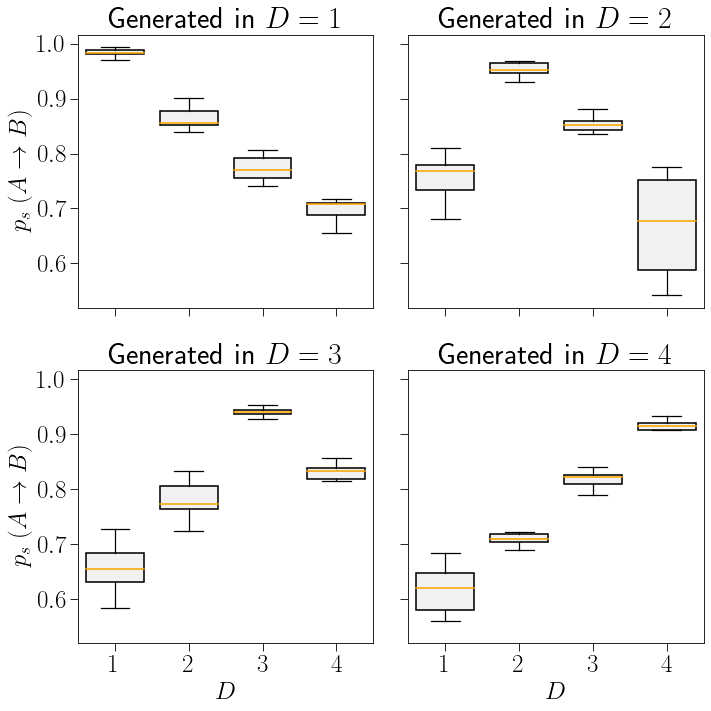

In [292]:
plot_success_rate(df_all, 'p_s_node_feature', r'$p_s$ $(A \rightarrow B)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/bipartite_gr_A_B_p_s.pdf")

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_A_B_p_s_gn2_5_gf3_5_b2_5.pdf")
# plt.show()

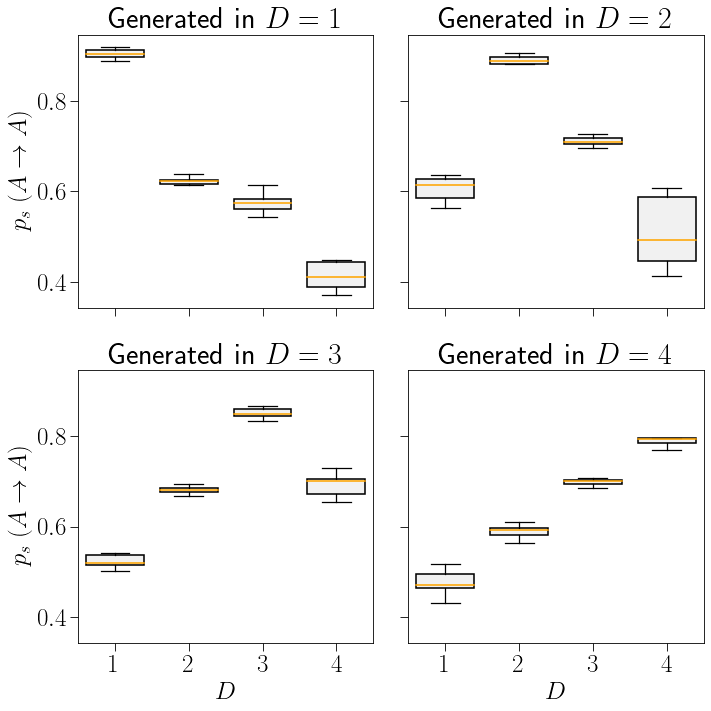

In [293]:
plot_success_rate(df_all, 'p_s_node_node', r'$p_s$ $(A \rightarrow A)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_A_A_p_s_gn2_5_gf3_5_b2_5.pdf")

plt.show()

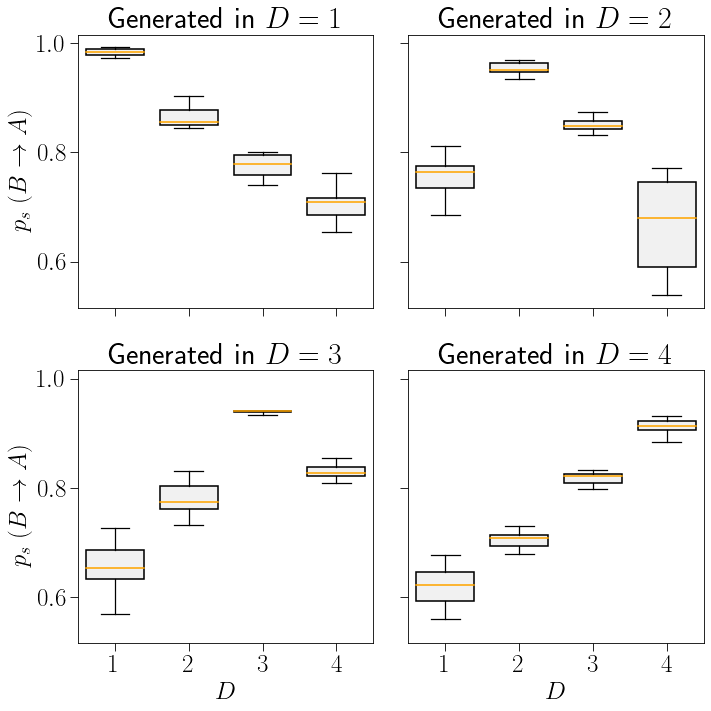

In [294]:
plot_success_rate(df_all, 'p_s_feature_node', r'$p_s$ $(B \rightarrow A)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_B_A_p_s_gn2_5_gf3_5_b2_5.pdf")

plt.show()

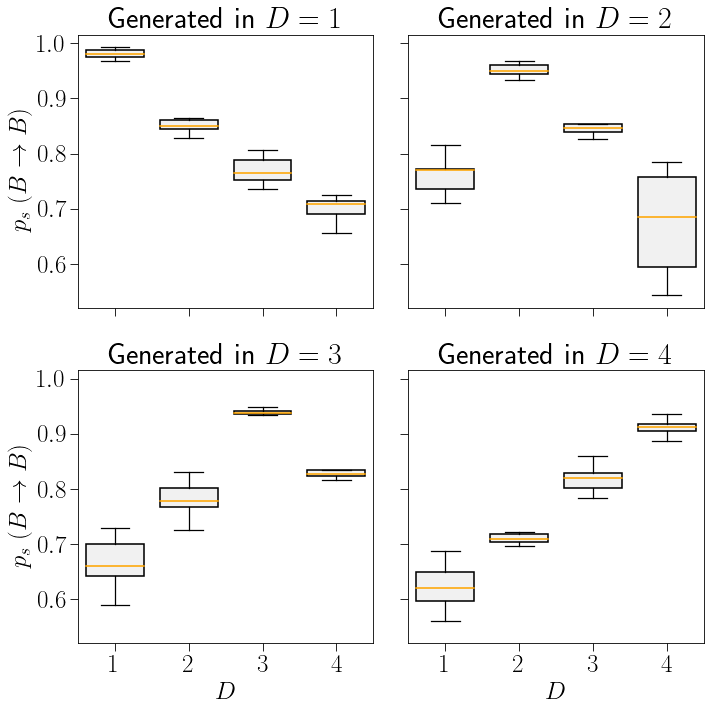

In [295]:
plot_success_rate(df_all, 'p_s_feature_feature', r'$p_s$ $(B \rightarrow B)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_B_B_p_s_gn2_5_gf3_5_b2_5.pdf")

plt.show()

---

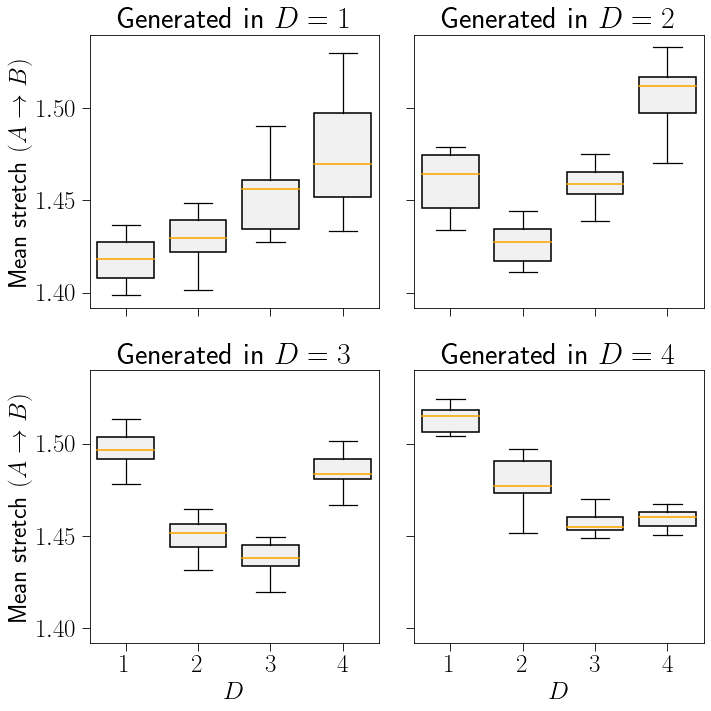

In [296]:
plot_success_rate(df_all, 'ms_node_feature', r'Mean stretch $(A \rightarrow B)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/bipartite_gr_A_B_mean_stretch.pdf")
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_A_B_mean_stretch_gn2_5_gf3_5_b2_5.pdf")


plt.show()

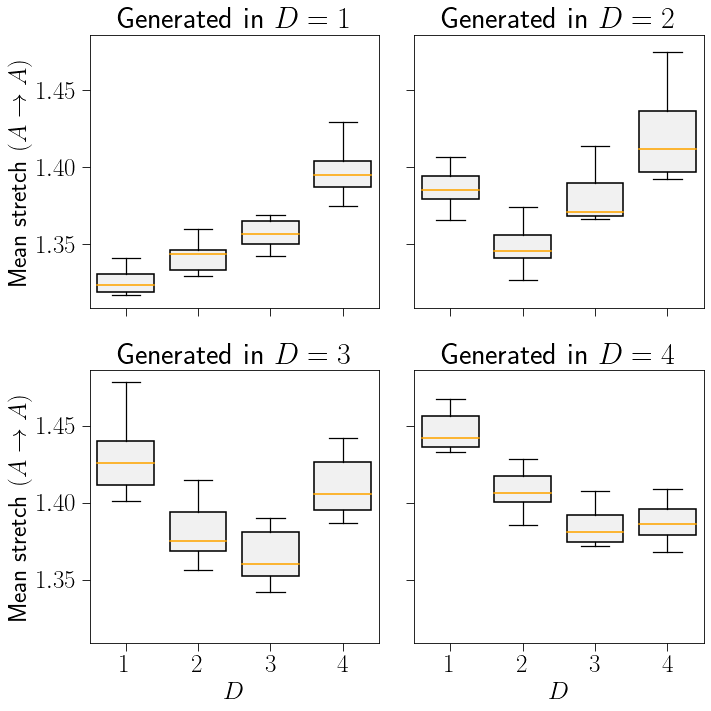

In [297]:
plot_success_rate(df_all, 'ms_node_node', r'Mean stretch $(A \rightarrow A)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_A_A_mean_stretch_gn2_5_gf3_5_b2_5.pdf")

plt.show()

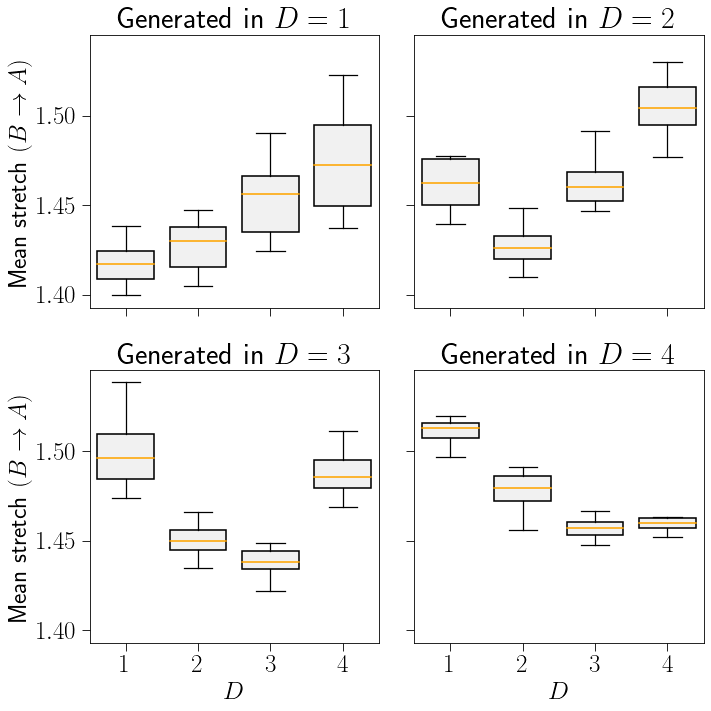

In [298]:
plot_success_rate(df_all, 'ms_feature_node', r'Mean stretch $(B \rightarrow A)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_B_A_mean_stretch_gn2_5_gf3_5_b2_5.pdf")

plt.show()

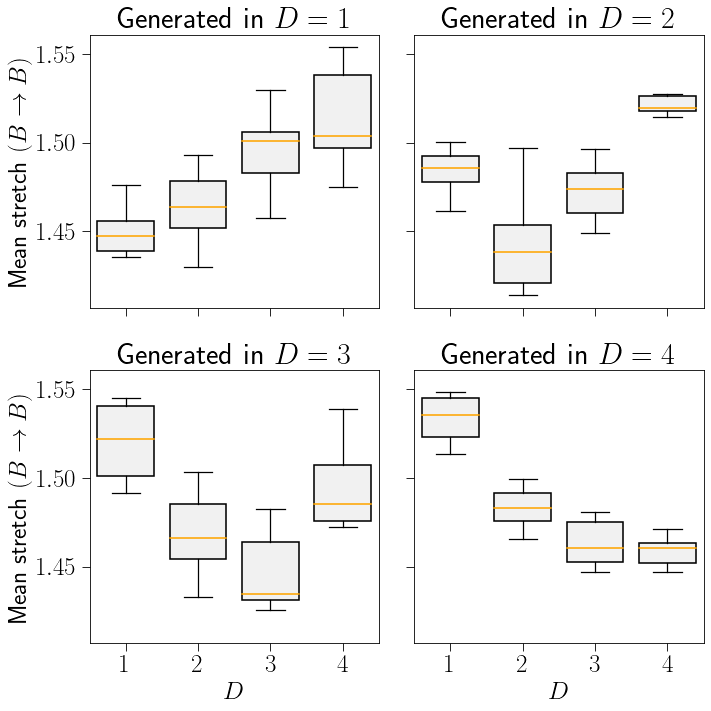

In [299]:
plot_success_rate(df_all, 'ms_feature_feature', r'Mean stretch $(B \rightarrow B)$', gamma_n, gamma_f, beta_b)
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/bipartite_gr_B_B_mean_stretch_gn2_5_gf3_5_b2_5.pdf")

plt.show()